In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import nltk
from string import punctuation
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
  
wn = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score,f1_score,classification_report
ps = PorterStemmer()

from catboost import CatBoostClassifier

import string
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')


In [ ]:
df_train.head()

In [ ]:
df_test.head()


# 1. Data analysis and exploration

# # Problem statement
the purpose of this notebook is to analyze and explore the given dataset ' df_train ' and create a machine learning model to be able to classify test tweets data into announcing disaster or not.

# # Data Exploration

Here we have 3 data sets 
1. train.csv - the training set
2. test.csv - the test set
3. sample_submission.csv - a sample submission file in the correct format

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
# Define a function to explore the train and test dataframes
def explore_data(df):
    
    
    '''Input- df= pandas dataframes to be explored
       Output- print shape, info and first 5 records of the dataframe 
    '''
    
    print("-"*50)
    print('Shape of the dataframe:',df.shape)
    print("Number of records in train data set:",df.shape[0])
    print("Information of the dataset:")
    df.info()
    print("-"*50)
    print("First 5 records of the dataset:")
    return df.head()
    print("-"*50)

In [ ]:
explore_data(df_train)


In [ ]:
explore_data(df_test)


In [ ]:
#Let's define a function to explore the missing values for the two datasets

def missing_values(df):
    print('{}% of location values are missing from Total Number of Records.'.format(round((df.location.isnull().sum())/(df.shape[0])*100),2))
    print('{}% of keywords values are missing from Total Number of Records.'.format(round((df.keyword.isnull().sum())/(df.shape[0])*100),2))
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False)
    null_feat = pd.DataFrame(len(df['id']) - df.isnull().sum(), columns = ['Count'])

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey', line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values")
                    
    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)




In [ ]:
#let's use the missing_values function to see the missing values in the train dataset
missing_values(df_train)

In [ ]:
#Now lets see the missing values in the test dataset
missing_values(df_test)


the column Location can be dropped

In [ ]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

In [ ]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

# # Class distribution 
### lets see the class distibution for 0 and 1 

We have to predict whether a given tweet is about a real disaster or not.
If real disaster, predict a 1. If not, predict a 0.

In [ ]:
print('Target of 0 is {} % of total'.format(round(df_train['target'].value_counts()[0]/len(df_train['target'])*100)))
print('Target of 1 is {} % of total'.format(round(df_train['target'].value_counts()[1]/len(df_train['target'])*100)))
x=df_train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

let's visulize top 10 location 

In [ ]:
sns.barplot(y=df_train['location'].value_counts()[:10].index,x=df_train['location'].value_counts()[:10],orient='h');

Since it doesn't seem that location feature has any value or correlation to our problem to be solved, it could be dropped from the data frame.

In [ ]:
# Drop the column 'location' from the training dataset
df_train=df_train.drop(['location'],axis=1)

Let’s look at what the disaster and the non disaster tweets look like.

In [ ]:
# A disaster tweet exmaple
df_train[df_train['target']==1]['text'][10:20]

In [ ]:
#A non-disaster tweet example
df_train[df_train['target']==0]['text'][10:20]


We can see clearly that disaster tweets are written in a more formal way with longer words compared to non-disaster tweets

In [ ]:

df_train['words_count'] = df_train['text'].str.split().map(lambda x: len(x))
df_train.head()

In [ ]:
#Create visualization of the distribution of the word counts in comparision to target feature
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
dis_tweet=df_train[df_train['target']==1]['words_count']
ax1.hist(dis_tweet,color='blue')
ax1.set_title('Disaster tweets')
ax1.grid()
nondis_tweet=df_train[df_train['target']==0]['words_count']
ax2.hist(nondis_tweet,color='red')
ax2.set_title('Non-disaster tweets')
ax2.grid()
fig.suptitle('Words in a tweet')
plt.show()

Lets further analyze the text feature and if there is any correlation between text content and length of the tweets itself.

Adding a new column text_length to train dataset 

In [ ]:
df_train['text_length'] = df_train['text'].apply(lambda x : len(x))
df_train.head()

In [ ]:
#Create visualization of the distribution of text length in comparision to target feature
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(10,6))
sns.distplot(df_train[(df_train['target'] == 1)]['text_length'], ax=ax1, kde=False, color='blue',label='Disater Tweets')
sns.distplot(df_train[(df_train['target'] == 0)]['text_length'],ax=ax2, kde=False, color='red',label='Non-Disater Tweets');
f.suptitle('Tweet length distribution')
f.legend(loc='upper right')
ax1.grid()
ax2.grid()
plt.show()

# 2. Data Preprocessing

# 3 Data Cleaning
Before starting any NLP project, text data needs to be pre-processed to convert it into in a consistent format.Text will be cleaned, tokneized and converted into a matrix.



# Step 1: Punctuation



To remove the punctuation in our dataset, let’s create a function and apply the function to the dataset:

In [ ]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation ]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

# Remove punctuation from both train and test dataset
df_train['text_wo_punct']=df_train['text'].apply(lambda x: remove_punctuation(x))
df_test['text_wo_punct']=df_test['text'].apply(lambda x: remove_punctuation(x))

df_train.head()

The column after step 1 has removed the punctuations from the text.


# Step 2: Tokenization
Tokenizing is the process of splitting strings into a list of words. We will make use of Regular Expressions or regex to do the splitting. Regex can be used to describe a search pattern.

In [ ]:
def tokenize(text):
    split=re.split("\W+",text) 
    return split
df_train['text_wo_punct_split']=df_train['text_wo_punct'].apply(lambda x: tokenize(x.lower()))
df_test['text_wo_punct_split']=df_test['text_wo_punct'].apply(lambda x: tokenize(x.lower()))

df_train.head()


Here, “\W+” splits on one or more non-word character


# Step 3: Stop words
Now, we have a list of words without any punctuation. Let’s go ahead and remove the stop words. Stop words are irrelevant words that won’t help in identifying a text as real or fake. We will use “nltk” library for stop-words and some of the stop words in this library are :

In [ ]:
stopword = nltk.corpus.stopwords.words('english')
print(stopword[:11])

There are 179 stop words in this library.

In [ ]:
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

df_train['text_wo_punct_split_wo_stopwords']=df_train['text_wo_punct_split'].apply(lambda x: remove_stopwords(x))
df_test['text_wo_punct_split_wo_stopwords']=df_test['text_wo_punct_split'].apply(lambda x: remove_stopwords(x))
df_train.head()

The column after step 3 has removed the unnecessary stop words.


# Step 4 : Lemmatize/ Stem
Stemming and Lemmatizing is the process of reducing a word to its root form. The main purpose is to reduce variations of the same word, thereby reducing the corpus of words we include in the model. The difference between stemming and lemmatizing is that, stemming chops off the end of the word without taking into consideration the context of the word. Whereas, Lemmatizing considers the context of the word and shortens the word into its root form based on the dictionary definition. Stemming is a faster process compared to Lemmantizing. Hence, it a trade-off between speed and accuracy.


Let’s consider the word “belief” for example.
The different variations of believe can be believing, believed, believes, and believe .

In [ ]:
print(ps.stem('believe'))
print(ps.stem('believing'))
print(ps.stem('believed'))
print(ps.stem('believes'))

The stem results for all of the above is believ


In [ ]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer=nltk.stem.WordNetLemmatizer()

print(lemmatizer.lemmatize('believe'))
print(lemmatizer.lemmatize('believing'))
print(lemmatizer.lemmatize('believed'))
print(lemmatizer.lemmatize('believes'))


The lemmatize results in the order of print statements are — believe, believing, believed, and belief.
Lemmatize produces the same result if the word is not in the corpus. Believe is lemmatized to belief (the root word)

We are going lemmatize our text

In [ ]:
def lemmatize_text(word_list):
    
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output


df_train['text_wo_punct_split_wo_stopwords_lim']=df_train['text_wo_punct_split_wo_stopwords'].apply(lambda x: lemmatize_text(x))
df_test['text_wo_punct_split_wo_stopwords_lim']=df_test['text_wo_punct_split_wo_stopwords'].apply(lambda x: lemmatize_text(x))
df_train.head()

# Step 5: other clearning steps 
    1.Remove URLs
    2.Remove HTML tags
    3.Remove emoji
    4.Remove numbers 

I will be defining a new fuction to perform the cleaning

In [ ]:
def text_clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub('<.*?>+', '', text)
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    text = ''.join([i for i in text if not i.isdigit()])
    return text


In [ ]:
df_train['clean_text']=df_train['text_wo_punct_split_wo_stopwords_lim'].apply(lambda x: text_clean(x))
df_test['clean_text']=df_test['text_wo_punct_split_wo_stopwords_lim'].apply(lambda x: text_clean(x))
df_train.head()

# 4. Text Vectorization

Word Embeddings or Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics.

To convert string data into numerical data one can use following methods
* · Bag of words
* · TFIDF
* · Word2Vec


# Google Word2Vec
 It is deep learning technique with two-layer neural network.Google Word2vec take input from large data and convert into vector space. 
 Google word2vec is basically pretrained on google dataset.
 
**Word2vec** basically place the word in the feature space is such a way that their location is determined by their meaning i.e. words having similar meaning are clustered together and the distance between two words also have same meaning. Consider an example given below:

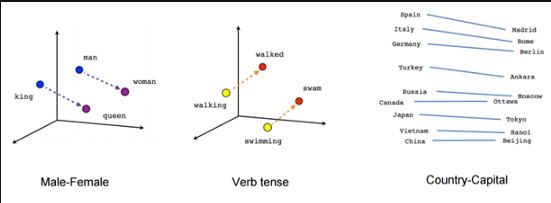

1. Bag of Words
The bag of words is a representation of text that describes the occurrence of words within a document. It involves two things:

* A vocabulary of known words.
* A measure of the presence of known words.

Why is it is called a “bag” of words? 

Its called bag of words because any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document.

**Bag of Words - Countvectorizer Features**
Countvectorizer converts a collection of text documents to a matrix of token counts. It is important to note that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal. However, all the pre-processing of the text has already been performed by creating a function.Only vanilla version of Countvectorizer will be used.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# Vectorize the text using CountVectorizer
count_vectorizer = CountVectorizer()
train_cv = count_vectorizer.fit_transform(df_train['clean_text'])
test_cv = count_vectorizer.transform(df_test["clean_text"])

## Keeping only non-zero elements to preserve space 
print(train_cv[0].todense())

# 5. Build a Text Classification model

Lets create a simple classification model using commonly used calssification algorithms and check how the models performs.



**Training and Testing Sets**
Like any other supervised machine learning problem, we need to divide our data into training and testing sets. To do so, we will use the train_test_split utility from the sklearn.model_selection

In [ ]:
from sklearn.model_selection import train_test_split

#Split the CountVector vectorized data into train and test datasets for model training and testing
X_train, X_test, y_train, y_test =train_test_split(train_cv,df_train.target,test_size=0.2,random_state=2020)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

1. ** Random Forest Algorithm**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RDclassifier = RandomForestClassifier(n_estimators=1000, random_state=0)
RDclassifier.fit(X_train,y_train)

In [ ]:
y_pred = RDclassifier.predict(X_test)

Evaluating the Algorithm

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

Tying the xgboost classifier 

In [ ]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
# make predictions for test data
y_pred2 = model.predict(X_test)


In [ ]:
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))
print(accuracy_score(y_test, y_pred2))

Saving and Loading the Model


We can save our model as a pickle object in Python.

In [ ]:
import pickle

with open('text_classifier', 'wb') as picklefile:
    pickle.dump(RDclassifier,picklefile)

To load the model


In [ ]:
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

In [ ]:
y_pred2 = model.predict(test_cv)

# print(confusion_matrix(y_test, y_pred2))
# print(classification_report(y_test, y_pred2))
# print(accuracy_score(y_test, y_pred2)) 

The output is similar to the one we got earlier which showed that we successfully saved and loaded the model.



In [ ]:
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
data={"id":[],"target":[]}
for id,pred in zip(sample_submission['id'].unique(),y_pred2): 
    data["id"].append(id) 
    data["target"].append(pred)

    
output=pd.DataFrame(data,columns=["id","target"])
output
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")